## Importing Libraries


In [1]:
# importing libraries
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim
from tqdm import tqdm
from torchsummary import summary
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


## Loading dataset and checking it out

In [30]:
# Loading dataset
data = pd.read_csv("/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv")

data.head() # checking first five values of each column

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [31]:
# Checking unique values in each column to understand the distinct entries in the dataset
# This helps to identify categorical variables and any unexpected or missing values

unique_values = {col: data[col].unique() for col in data.columns}

# Displaying the unique values found in each column

unique_values

# Getting the value counts of the 'smoking_history' column to understand the distribution
# This will show how many patients have different smoking history statuses
value_counts = data['smoking_history'].value_counts()

# Printing the value counts of 'smoking_history' to check for any discrepancies or unexpected categories
print(value_counts)

# Removing rows where the 'smoking_history' column has 'No Info', as these rows have missing data for this feature
# This step is important to ensure that missing values don't affect the analysis or modeling process
data = data[data['smoking_history'] != 'No Info']

# Re-checking the unique values in each column after removing rows with 'No Info' in 'smoking_history'
# This ensures that the dataset is now cleaned and free of the unwanted 'No Info' category
unique_values = {col: data[col].unique() for col in data.columns}
unique_values

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64


{'gender': array(['Female', 'Male', 'Other'], dtype=object),
 'age': array([80.  , 28.  , 36.  , 76.  , 20.  , 44.  , 42.  , 32.  , 53.  ,
        54.  , 78.  , 67.  , 15.  , 37.  , 40.  , 69.  , 72.  , 30.  ,
        45.  , 43.  , 41.  , 26.  , 50.  , 34.  , 73.  , 77.  , 29.  ,
        60.  , 38.  , 57.  , 19.  , 21.  , 59.  , 27.  , 56.  , 79.  ,
        74.  , 55.  , 62.  , 47.  , 66.  , 68.  ,  5.  , 75.  , 22.  ,
        58.  , 24.  , 18.  , 33.  , 16.  , 46.  , 61.  , 31.  , 49.  ,
        25.  , 39.  , 65.  , 14.  , 70.  , 48.  , 11.  , 51.  , 17.  ,
         9.  , 64.  , 63.  , 52.  , 35.  ,  2.  , 71.  ,  4.  ,  6.  ,
         3.  , 23.  , 10.  , 13.  ,  1.24,  1.88, 12.  ,  7.  ,  8.  ,
         1.4 ,  1.16,  1.72,  0.24,  1.64,  1.32,  0.32,  0.16,  0.48,
         1.8 ,  0.88,  0.56,  1.08,  1.  ,  0.8 ,  1.48,  1.56,  0.72,
         0.4 ,  0.64]),
 'hypertension': array([0, 1]),
 'heart_disease': array([1, 0]),
 'smoking_history': array(['never', 'current', 'former', 'ever

In [32]:
# Mapping categorical values to numerical value
# We need to do this as torch tensors accept floating point numbers as input

data['gender'] = data['gender'].map({'Male': 1, 'Female': 0})
data['smoking_history'] = data['smoking_history'].map({'never': 0, 'former': 1, 'not current': 2, 'current':3, 'ever':4})

data.head()


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0.0,80.0,0,1,0,25.19,6.6,140,0
2,1.0,28.0,0,0,0,27.32,5.7,158,0
3,0.0,36.0,0,0,3,23.45,5.0,155,0
4,1.0,76.0,1,1,3,20.14,4.8,155,0
5,0.0,20.0,0,0,0,27.32,6.6,85,0


In [34]:
# checking data types
print(data.dtypes)

# All our columns are either int or float

gender                 float64
age                    float64
hypertension             int64
heart_disease            int64
smoking_history          int64
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


In [36]:
# Checking for null values and removing them 

print(data.isnull().sum())
data = data.dropna(subset=['gender'])


gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


## Normalizing dataset

In [38]:
# Normalizing dataset, where we use standardscalar to make the mean of equal 0 and standard deviation 1, this will help during training and avoid issies like exploding 
# gradients.

X = data.drop(columns=['diabetes'])  # All columns except 'diabetes'
y = data['diabetes']  # The target column


columns_to_normalize = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']  # the columns we will normalize

# Applying StandardScalar()
scaler = StandardScaler()
X[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])

# Recombining the normalized features back with the target column
data = pd.concat([X, y], axis=1)


data.head()


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0.0,1.712053,0,1,0,-0.496363,0.945409,0.008780,0
2,1.0,-0.949217,0,0,0,-0.169471,0.123887,0.435660,0
3,0.0,-0.539791,0,0,3,-0.763401,-0.515075,0.364513,0
4,1.0,1.507340,1,1,3,-1.271387,-0.697636,0.364513,0
5,0.0,-1.358643,0,0,0,-0.169471,0.945409,-1.295577,0


In [39]:
# lets look at shape of dataset
data.shape

# We have 64172 entries, with 8  features and 1 target variable 

(64172, 9)

## Splitting dataset and transforming to torch tensors

In [41]:
# Now that we preprocessed data we can start by splitting the data into train, validation and test sets

# Features and target splitting
X = data.drop(columns=['diabetes']).values  # Features
y = data['diabetes'].values  # Target

# First split: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split: 50% of temp goes to validation, 50% to test (so 15% each of total dataset)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Converting features and target to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


print(f"Train set size: {X_train.shape[0]} ({(X_train.shape[0] / len(X)) * 100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({(X_val.shape[0] / len(X)) * 100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({(X_test.shape[0] / len(X)) * 100:.1f}%)")


Train set size: 44920 (70.0%)
Validation set size: 9626 (15.0%)
Test set size: 9626 (15.0%)


## Defining torch Dataset and DataLoaders

In [42]:
# Defining a simple custom Dataset class whill will be fed with out train, val and test sets

class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [44]:
# Dataset objects for train, validation and test sets
train_dataset = DiabetesDataset(X_train_tensor, y_train_tensor)
val_dataset = DiabetesDataset(X_val_tensor, y_val_tensor)
test_dataset = DiabetesDataset(X_test_tensor, y_test_tensor)

# DataLoader objects for train, validation and test sets ( this is what we will use for the training and val loops)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle=False)


In [45]:
# We can first check one of the batches from each set to ensure proper size and everything is well

# Checking shape of a batch from the train_dataloader
for X_batch, y_batch in train_dataloader:
    print("Train batch features shape:", X_batch.shape)
    print("Train batch target shape:", y_batch.shape)
    break  # Only print the shape of the first batch

# Checking shape of a batch from the val_dataloader
for X_batch, y_batch in val_dataloader:
    print("Validation batch features shape:", X_batch.shape)
    print("Validation batch target shape:", y_batch.shape)
    break  # Only print the shape of the first batch

# Checking shape of a batch from the test_dataloader
for X_batch, y_batch in test_dataloader:
    print("Validation batch features shape:", X_batch.shape)
    print("Validation batch target shape:", y_batch.shape)
    break  # Only print the shape of the first batch

Train batch features shape: torch.Size([64, 8])
Train batch target shape: torch.Size([64])
Validation batch features shape: torch.Size([64, 8])
Validation batch target shape: torch.Size([64])
Validation batch features shape: torch.Size([64, 8])
Validation batch target shape: torch.Size([64])


In [46]:
# Checking other stuff related to null values and type of the entries in the batches, just to make sure again all is well.

for X_batch, y_batch in train_dataloader:
    print("Train batch features shape:", X_batch.shape)
    print("Train batch target shape:", y_batch.shape)
    
    # Print some random feature values (first 5 rows)
    print("First 5 feature values:", X_batch[:5])
    print("First 5 target values:", y_batch[:200])

    # Print the data type of the features
    print("Data type of features:", X_batch.dtype)
    
    # Check if there are NaN or Inf values
    if torch.isnan(X_batch).any() or torch.isinf(X_batch).any():
        print("Warning: NaN or Inf values found in features!")
    
    if torch.isnan(y_batch).any() or torch.isinf(y_batch).any():
        print("Warning: NaN or Inf values found in targets!")
    
    break  # Only print the details of the first batch


Train batch features shape: torch.Size([64, 8])
Train batch target shape: torch.Size([64])
First 5 feature values: tensor([[ 0.0000, -0.7957,  0.0000,  0.0000,  0.0000, -0.1695, -0.5151, -0.2284],
        [ 0.0000, -1.3075,  0.0000,  0.0000,  0.0000, -0.8969, -0.9715,  0.4357],
        [ 0.0000, -1.3586,  0.0000,  0.0000,  0.0000, -1.2177,  0.5803,  1.4317],
        [ 0.0000,  0.6373,  1.0000,  0.0000,  1.0000, -0.1695,  0.5803,  3.8033],
        [ 1.0000,  0.1255,  0.0000,  0.0000,  0.0000,  0.1896,  1.7669,  2.3803]])
First 5 target values: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Data type of features: torch.float32


## Defining classifier model (ANN)

### The classifier will be a simple ANN which starts with a linear layer which takes in some input size neurons equal to the number of features (in our case 8), then we pass into activation layer then another two linear layers:         linear(linear(Relu(linear(x))))

In [47]:
#We define our classifier class which is a simple ANN


class DiabetesClassifier(nn.Module):
    def __init__(self, input_size):
        super(DiabetesClassifier, self).__init__()
        
        # Define a simple feedforward network
        self.fc1 = nn.Linear(input_size, 64)  # First layer (input to hidden)
        self.relu = nn.ReLU()  # Activation function for hidden layer
        self.fc2 = nn.Linear(64, 32)  # Second layer (hidden to hidden)
        self.fc3 = nn.Linear(32, 1)  # Output layer (hidden to output)
    
    def forward(self, x):
        # Define the forward pass
        x = self.fc1(x)  # First layer
        x = self.relu(x)  # ReLU activation
        x = self.fc2(x)  # Second layer
        x = self.relu(x)  # ReLU activation
        x = self.fc3(x)  # Output layer (no sigmoid here)
        return x  # Return raw logits


# input tensor is 64 x 8 (as we have batch size = 64), after first linear it will be 64 x 64 and then after second linear 64 x 32 and finally it will be 64 x 1,
# so each of the 64 entries in the batch will have a single output value which will be normalized from 0 to 1 representing probability of having diabetes or not,

In [48]:
# initializing model with input_size = 8

model = DiabetesClassifier(8)
model

DiabetesClassifier(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [49]:
# checking number of paramters of the model as a whole and each individual layer

summary(model, input_size=(8,))  # For a model with 8 features as input


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             576
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 32]           2,080
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 1]              33
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [50]:
# We define a loss function, in this case Binary Cross entropy with Logits Loss as it best suits binary classification tasks, and as an optimizer we use Adam
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [52]:
# We can feed the untrained model with the data to see if it works

# Get a single batch from the train_dataloader
for X_batch, y_batch in train_dataloader:
    # Convert y_batch to float32 for compatibility with loss function (not strictly necessary )
    y_batch = y_batch.float()

    # Pass the batch through the model
    outputs = model(X_batch)  # Model output will have shape [64, 1]

    # Squeeze the output to remove the extra dimension (from [64, 1] to [64])
    outputs = outputs.squeeze()

    # Check a single output (just pick one example from the batch)
    print("Single output value:", outputs[0].item())  # outputs[0] gives the first value in the batch

    # Calculating the loss
    loss = loss_function(outputs, y_batch)  # y_batch is also in float32
    print("Loss for the batch:", loss.item())  # Getting the loss value

    break  # Exit the loop after checking one batch (optional, for debugging)


Single output value: 0.027062205597758293
Loss for the batch: 0.691676139831543


## Training loop

### Now that our data is ready in dataloaders and we defined our loss function and optimizer we can start our training loop. We use an arbitrary number of epochs and we feed the batches in the dataloader, to go through the training process. We will do this for validation as well to check if the model is generalizing or overfitting.

In [ ]:
# Arrays to store losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training Loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    running_train_correct = 0  # To count correct predictions
    total_train_samples = 0  # To count total samples

    # Training Phase (Training Data)
    with tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Train", unit="batch") as tepoch:
        for X_batch, y_batch in tepoch:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(X_batch)  # Forward pass

            loss = loss_function(outputs.squeeze(), y_batch.float())  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters
            running_train_loss += loss.item()

            # Compute accuracy
            preds = torch.sigmoid(outputs).squeeze()  # Convert logits to probabilities
            preds = torch.round(preds)  # Convert probabilities to binary (0 or 1)
            running_train_correct += (preds == y_batch).sum().item()
            total_train_samples += y_batch.size(0)

            # Update tqdm progress bar with current loss
            tepoch.set_postfix(loss=loss.item())

    avg_train_loss = running_train_loss / len(train_dataloader)  # Average training loss
    train_losses.append(avg_train_loss)  # Store training loss
    train_accuracy = running_train_correct / total_train_samples  # Compute training accuracy
    train_accuracies.append(train_accuracy)

    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    running_val_correct = 0  # To count correct predictions
    total_val_samples = 0  # To count total samples

    # Validation Phase (Validation Data)
    with torch.no_grad():  # No gradient tracking during  (that's the point of validation in the first place, to check that no overfitting is going on)
        with tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Val", unit="batch") as tepoch:
            for X_batch, y_batch in tepoch:
                outputs = model(X_batch)  # Forward pass
                loss = loss_function(outputs.squeeze(), y_batch.float())  # Compute loss
                running_val_loss += loss.item()

                # Compute accuracy
                preds = torch.sigmoid(outputs).squeeze()
                preds = torch.round(preds)
                running_val_correct += (preds == y_batch).sum().item()
                total_val_samples += y_batch.size(0)

                # Update tqdm progress bar with current loss
                tepoch.set_postfix(loss=loss.item())

    avg_val_loss = running_val_loss / len(val_dataloader)  # Average validation loss
    val_losses.append(avg_val_loss)  # Store validation loss
    val_accuracy = running_val_correct / total_val_samples  # Compute validation accuracy
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")


print("\nFinal Training and Validation Metrics:")
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")
print(f"Train Accuracies: {train_accuracies}")
print(f"Validation Accuracies: {val_accuracies}")


Epoch 1/5 - Val: 100%|██████████| 151/151 [00:00<00:00, 403.32batch/s, loss=0.0444]


Epoch 1/5 - Train Loss: 0.1777, Train Acc: 0.9405, Val Loss: 0.1330, Val Acc: 0.9517


Epoch 2/5 - Val: 100%|██████████| 151/151 [00:00<00:00, 409.14batch/s, loss=0.0382]


Epoch 2/5 - Train Loss: 0.1340, Train Acc: 0.9516, Val Loss: 0.1239, Val Acc: 0.9560


Epoch 3/5 - Train:  83%|████████▎ | 582/702 [00:02<00:00, 245.96batch/s, loss=0.159] 

## Training and Validation loss and Accuracy plots

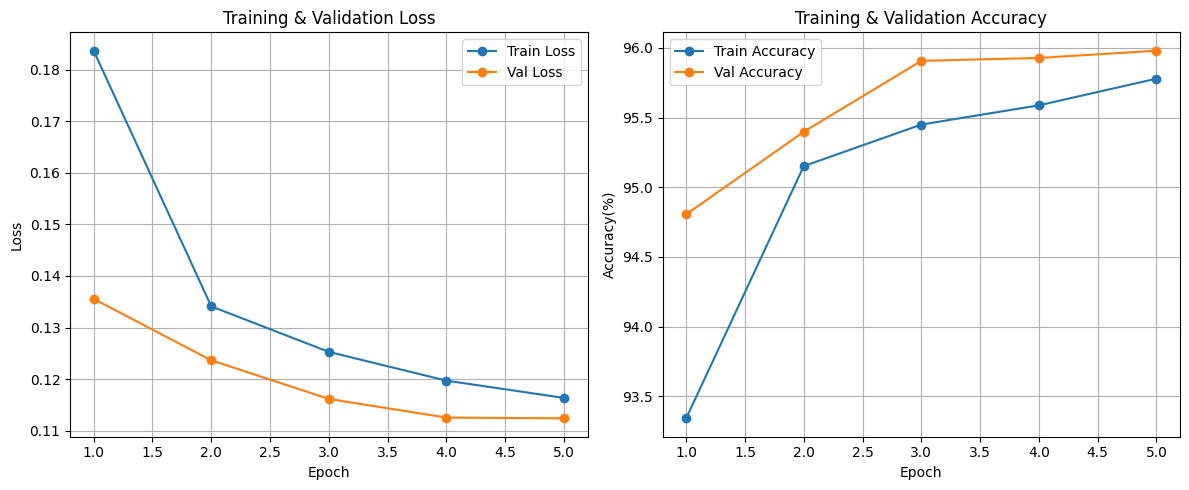

In [27]:


# Cretaing an arry for the number of epochs
epochs = np.arange(1, num_epochs + 1)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training & Validation Loss plot
axes[0].plot(epochs, train_losses, label="Train Loss", marker="o")
axes[0].plot(epochs, val_losses, label="Val Loss", marker="o")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend()
axes[0].grid()

# Training & Validation Accuracy plot
axes[1].plot(epochs, np.array(train_accuracies)*100, label="Train Accuracy", marker="o")
axes[1].plot(epochs, np.array(val_accuracies)*100, label="Val Accuracy", marker="o")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy(%)")
axes[1].set_title("Training & Validation Accuracy")
axes[1].legend()
axes[1].grid()


plt.tight_layout()
plt.savefig('Loss_&_accuracy_plots.png')
plt.show()


## Test loop

In [23]:
# Now that we trained the model we can try to see how it performs in the test dataset


# Setting model to evaluation mode as we are doing inference ()
model.eval()

# Initializing running loss and accuracy
running_test_loss = 0.0
correct_predictions = 0
total_samples = 0

# No need to track gradients during testing (hence why we set model to eval mode)
with torch.no_grad():
    with tqdm(test_dataloader, desc="Testing", unit="batch") as tepoch:
        for X_batch, y_batch in tepoch:
            # Forward pass
            outputs = model(X_batch)
            
            # Compute loss
            loss = loss_function(outputs.squeeze(), y_batch.float())
            running_test_loss += loss.item()

            # Compute accuracy
            predicted = (torch.sigmoid(outputs.squeeze()) >= 0.5).long()  # Convert logits to binary labels
            correct_predictions += (predicted == y_batch).sum().item()
            total_samples += y_batch.size(0)

            # Updating tqdm progress bar with current loss
            tepoch.set_postfix(loss=loss.item())

# Compute average test loss and accuracy
avg_test_loss = running_test_loss / len(test_dataloader)
test_accuracy = correct_predictions / total_samples

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4%}")


Testing: 100%|██████████| 151/151 [00:00<00:00, 397.81batch/s, loss=0.0381]


Test Loss: 0.1123
Test Accuracy: 95.9069%


## Impact of each feature

### After training and checked that we have good value for testing, we are pretty much done, but as a final check we can look into the impact of each feature on the prediction of diabetes and which one is the most relevant. We do this by looking at the weights in the first layer and see which one is the highest weight (hence which feature is the target most sensitive to)

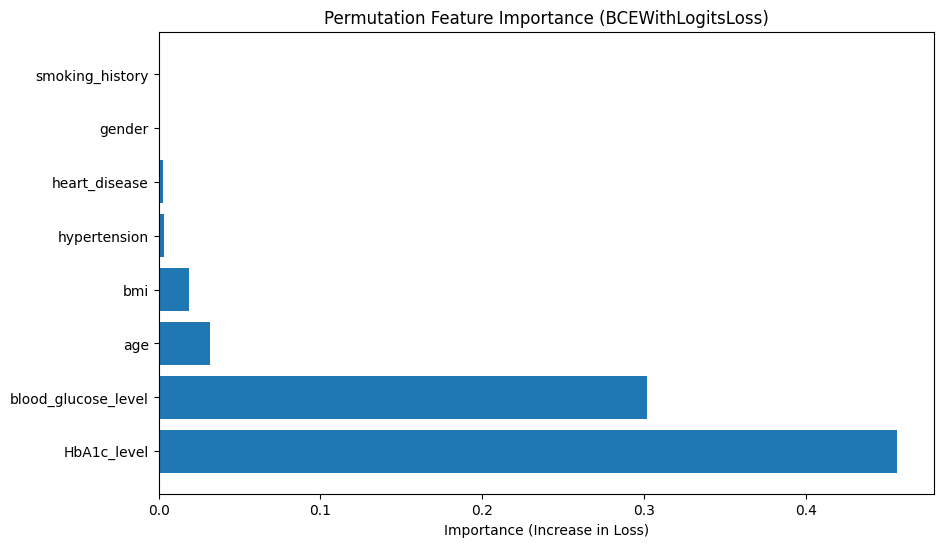

In [26]:
# We define a permutation function which shuffles each values in a certain feature and calculates the change in loss from doing this and we do it for each feature
# independently, so that we can get an idea of which feature is the most relevant.

def permutation_importance_bce(model, dataloader, X, y, num_features, criterion):
    """
    Calculate the permutation importance of each feature using BCEWithLogitsLoss.
    :param model: The trained PyTorch model.
    :param dataloader: The data loader with the features and targets.
    :param X: The original feature matrix.
    :param y: The original target values.
    :param num_features: Number of features in the dataset.
    :param criterion: The loss function (BCEWithLogitsLoss in this case).
    :return: List of feature importances.
    """

    # Calculate the baseline loss (BCEWithLogitsLoss) on the original data
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(X)
        original_loss = criterion(outputs.squeeze(), y.float()).item()

    # Calculate permutation importance for each feature
    importances = []
    
    for i in range(num_features):
        # Shuffle the i-th feature (X[:, i])
        X_permuted = X.clone()
        X_permuted[:, i] = X_permuted[torch.randperm(X_permuted.size(0)), i]
        
        # Calculate the loss after permuting the feature
        with torch.no_grad():
            outputs = model(X_permuted)
            permuted_loss = criterion(outputs.squeeze(), y.float()).item()
        
        # Calculate the importance as the increase in loss
        importance = permuted_loss - original_loss
        importances.append(importance)
    
    # Sort features by importance
    sorted_idx = np.argsort(importances)[::-1]  # Sort in descending order
    return sorted_idx, importances

# defining our loss_fn/criterion 
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits
sorted_idx, importances = permutation_importance_bce(model, train_dataloader, X_train_tensor, y_train_tensor, X_train_tensor.size(1), criterion)


feature_names = ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# We plot the increase in loss that comes from shuffling the feature values for each feature as a bar plot
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], np.array(importances)[sorted_idx])
plt.xlabel('Importance (Increase in Loss)')
plt.title('Permutation Feature Importance (BCEWithLogitsLoss)')
plt.savefig("Feature_relevance.png")
plt.show()



### We can clearly see that hbA1c level is the most impactful parameter in the prediction of diabetes